In [14]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [33]:
import workshop
workshop.download_tag_prediction()
DATA_DIR='tag-prediction'

File tag-prediction/train.tsv is already downloaded.
File tag-prediction/validation.tsv is already downloaded.
File tag-prediction/test.tsv is already downloaded.
File tag-prediction/text_prepare_tests.tsv is already downloaded.


In [28]:
!ls ./

data	    __pycache__     TagsPrediction.ipynb  workshop.py
lost+found  tag-prediction  tqdm_utils.py


In [29]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [37]:
??literal_eval

In [34]:

def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data


In [35]:

train = read_data(DATA_DIR+'/train.tsv')
validation = read_data(DATA_DIR+'/validation.tsv')
test = pd.read_csv(DATA_DIR+'/test.tsv', sep='\t')


In [36]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


In [38]:

X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values


In [39]:
import re

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = re.sub('[/(){}\[\]\|@,;]',' ', text)# replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub('[^0-9a-z #+_]', '', text)# delete symbols which are in BAD_SYMBOLS_RE from text
    text = [word for word in text.split(' ') if len(word) > 0 and word not in STOPWORDS]
    return ' '.join(text)


In [40]:

def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'


In [41]:

print(test_text_prepare())


Basic tests are passed.


In [42]:

prepared_questions = []
for line in open('data/text_prepare_tests.tsv', encoding='utf-8'):
    line = text_prepare(line.strip())
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)


In [43]:

X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]


In [44]:
X_train[:3]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

In [45]:

# Dictionary of all tags from train corpus with their counts.
tags_counts = {}
# Dictionary of all words from train corpus with their counts.
words_counts = {}


for txt in X_train:
    for word in txt.split(' '):
        if word not in words_counts:
            words_counts[word] = 0
        words_counts[word] += 1
        
for tags in y_train:
    for tag in tags:
        if tag not in tags_counts:
            tags_counts[tag] = 0
        tags_counts[tag] += 1
        


In [46]:

most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

print(most_common_tags)
print(most_common_words)


[('javascript', 19078), ('c#', 19077), ('java', 18661)]
[('using', 8278), ('php', 5614), ('java', 5501)]


In [47]:
DICT_SIZE = 5000
sorted_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)
sorted_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE]

WORDS_TO_INDEX = dict([(pair[0],idx) for idx, pair in enumerate(sorted_words)])
INDEX_TO_WORDS = dict([(idx,word) for word,idx in WORDS_TO_INDEX.items()])
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    for word in text.split(' '):
        if word not in words_to_index:
            continue;
        result_vector[words_to_index[word]] += 1
    return result_vector

In [48]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [49]:
print(test_my_bag_of_words())

Basic tests are passed.


In [50]:
from scipy import sparse as sp_sparse

In [51]:

X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)


X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


In [52]:

row = X_train_mybag[10].toarray()[0]
non_zero_elements_count = len([val for val in row if val!=0])
print(non_zero_elements_count)


7


In [53]:

from sklearn.feature_extraction.text import TfidfVectorizer


In [54]:

def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words=STOPWORDS, token_pattern = '(\S+)', 
                                       ngram_range=(1,2), max_df = 0.9, min_df = 5)
    
    X_train = tfidf_vectorizer.fit_transform(X_train)
    
    X_test = tfidf_vectorizer.transform(X_test)
    
    X_val = tfidf_vectorizer.transform(X_val)
    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_


In [55]:

tfidf_vectorizer = TfidfVectorizer(stop_words=STOPWORDS, ngram_range=(1,2), max_df = 0.9, min_df = 5)

tfidf_vectorizer.fit_transform(X_train)


<100000x17778 sparse matrix of type '<class 'numpy.float64'>'
	with 653252 stored elements in Compressed Sparse Row format>

In [56]:

X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}


In [57]:

from sklearn.preprocessing import MultiLabelBinarizer


In [58]:

mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train_b = mlb.fit_transform(y_train)
y_val_b = mlb.fit_transform(y_val)


In [59]:

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier


In [60]:

def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
        
    clf = OneVsRestClassifier(LogisticRegression(), -1)
    
    clf.fit(X_train, y_train)
    
    return clf
    
    


In [61]:

classifier_mybag = train_classifier(X_train_mybag, y_train_b)
classifier_tfidf = train_classifier(X_train_tfidf, y_train_b)


In [62]:

y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)


In [63]:

y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_mybag)
y_val_inversed = mlb.inverse_transform(y_val_b)
for i in range(10):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))


Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	ruby-on-rails


Title:	sessions sinatra used pass variable
True labels:	ruby,session
Predicted labels:	ruby


Title:	getting error type json exist postgresql rake db migrate
True labels:	json,ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails


Title:	library found
True labels:	c++,ios,iphone,xcode
Predicted labels:	


Title:	csproj file programmatic adding deleting files
True labels:	c#
Predicted labels:	


Title:	typeerror makedirs got unexpected keyword argument exists_ok
True labels:	django,python
Predicted labels:	python


Title:	pan div using jquery
True labels:	html,javascript,jquery
Predicted labels:	javascript,jquery


Title:	hibernate intermediate advanced tutorials
True labels:	hibernate,java
Predicted 

In [64]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score


In [65]:

def print_evaluation_scores(y_val, predicted):
    
    acc = accuracy_score(y_val, predicted)
    
    micro_f1 = f1_score(y_val, predicted, average = 'micro')
    macro_f1 = f1_score(y_val, predicted, average = 'macro')
    weighted_f1 = f1_score(y_val, predicted, average = 'weighted')
    
    micro_prec = average_precision_score(y_val, predicted, average = 'micro')
    macro_prec = average_precision_score(y_val, predicted, average = 'macro')
    weighted_prec = average_precision_score(y_val, predicted, average = 'weighted')

    print('Accuracy: ', acc)
    print('F1 micro: ', micro_f1)
    print('F1 macro: ', macro_f1)
    print('F1 weighted: ', weighted_f1)
    
    print('Avg Precision micro: ', micro_prec)
    print('Avg Precision macro: ', macro_prec)
    print('Avg Precision weighted: ', weighted_prec)
    
    


In [66]:

print('Bag-of-words')
print_evaluation_scores(y_val_b, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val_b, y_val_predicted_labels_tfidf)


Bag-of-words
Accuracy:  0.358
F1 micro:  0.6710820449370445
F1 macro:  0.5047325582597497
F1 weighted:  0.6486950381244107
Avg Precision micro:  0.4812849070834009
Avg Precision macro:  0.34458812912520126
Avg Precision weighted:  0.5108520393587743
Tfidf
Accuracy:  0.33393333333333336
F1 micro:  0.6418233967551946
F1 macro:  0.44570945215918634
F1 weighted:  0.6143634328155098
Avg Precision micro:  0.4570020540292232
Avg Precision macro:  0.3020320489939477
Avg Precision weighted:  0.4851114604464971


In [77]:
from metrics import roc_auc
%matplotlib inline


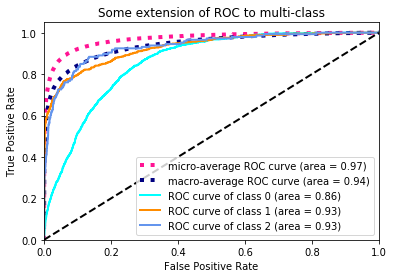

In [78]:

n_classes = len(tags_counts)
roc_auc(y_val_b, y_val_predicted_scores_mybag, n_classes)


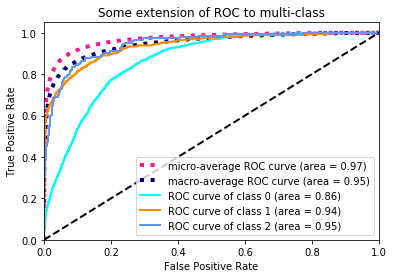

In [79]:

n_classes = len(tags_counts)
roc_auc(y_val_b, y_val_predicted_scores_tfidf, n_classes)


In [80]:

def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    # Extract an estimator from the classifier for the given tag.
    # Extract feature coefficients from the estimator. 
        
    idx = tags_classes.index(tag)
    coef = classifier_tfidf.coef_[idx]
    cd = {i:coef[i] for i in range(len(coef))}
    scd=sorted(cd.items(), key=lambda x: x[1], reverse=True)
    
    top_positive_words = [index_to_words[k[0]] for k in scd[:5]] # top-5 words sorted by the coefficiens.
    top_negative_words = [index_to_words[k[0]] for k in scd[-5:]] # bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))


In [81]:

print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)


Tag:	c
Top positive words:	c, malloc, scanf, printf, gcc
Top negative words:	c#, javascript, python, php, java

Tag:	c++
Top positive words:	c++, qt, boost, mfc, opencv
Top negative words:	c#, javascript, python, php, java

Tag:	linux
Top positive words:	linux, ubuntu, c, address, signal
Top negative words:	method, array, jquery, c#, javascript

